In [6]:
from __future__ import annotations
from typing import Iterable, Union

import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:

def my_sampler(size: int, dist: Iterable[float], requires_grad: bool = False):
    """ Creating a tensor of samples of size `size` using `dist` as distribution.
    work similarly to numpy random choice.

    :param size: tensor size. if size=5 will return tensor of size 5
    :param dist: distribution of sampling, for example
                 dist[1] is the chance to sample the number 1
                 all numbers in dist should be positive and sum to 1
    :param requires_grad:
    :return: torch.Tensor of dtype int32
    """
    dist = torch.Tensor(dist)

    is_dist_correct = sum(dist) == 1. and all(dist > 0.)
    if not is_dist_correct:
        raise ValueError(f"dist: {dist} is invalid.\n"
                         f"Hint: all values should be positive and sum to 1")

    # Once we cumsum the probability vector, we can find a random variable place in it.
    dist_cumsum = torch.cumsum(dist, dim=0, dtype=torch.float32)

    # Sampling `size` uniform values
    uni_randoms = torch.rand(size)

    # Searching in sorted array could be performed using binary search.
    # I can implement it, but why not using a torch implementation, which already
    # handles all the edge cases

    # We will also vectorize the operation instead running in a for loop
    result_tensor = torch.searchsorted(dist_cumsum, uni_randoms, out_int32=True)
    result_tensor.required_grad = requires_grad

    return result_tensor

#### - Defining the given distribution
#### - Sampling 10K samples.
#### - Plotting the histogram

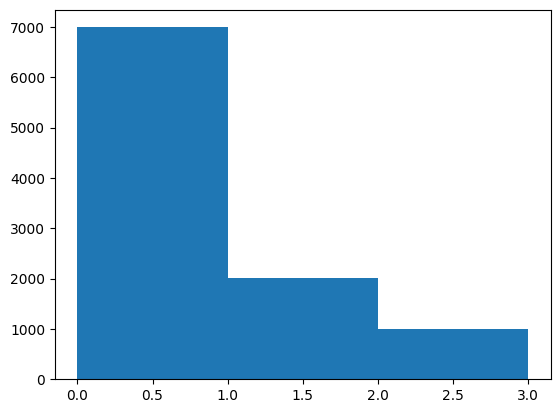

In [3]:
dist = [0.7, 0.2, 0.1]
result_tensor = my_sampler(10_000, dist)
plt.hist(result_tensor, bins=[0, 1, 2, 3], linewidth=1.2)
plt.show()

### ERROR Show case: sum(dist) > 1

In [4]:
dist = [0.7, 0.4, 0.5]
result_tensor = my_sampler(10_000, dist)

ValueError: dist: tensor([0.7000, 0.4000, 0.5000]) is invalid.
Hint: all values should be positive and sum to 1

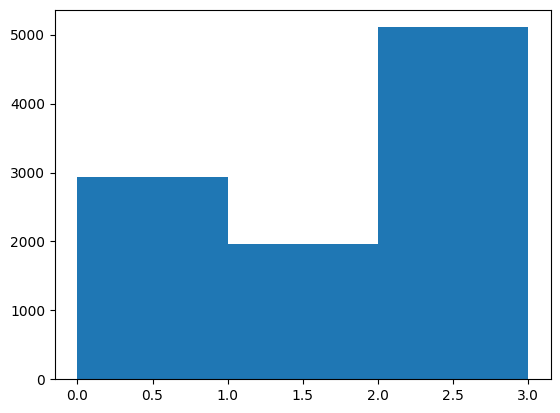

In [5]:
# A different distribution

dist = [0.3, 0.2, 0.5]
result_tensor = my_sampler(10_000, dist)
plt.hist(result_tensor, bins=[0, 1, 2, 3], linewidth=1.2)
plt.show()

## My Math

In [7]:
class MyScalar:
    def __init__(self,
                 val: Union[int, float],
                 im_derivative: Union[int, float] = None,
                 predecessor: MyScalar = None):
        self.val = val
        self.im_derivative = im_derivative
        self.predecessor = predecessor

    # Nice repr/print for debugging.
    def __repr__(self):
        return (f"(MyScalar:\n"
                f"\tval: {self.val}\n"
                f"\tderivative: {self.im_derivative}\n"
                f"\tpredecessor:\n{self.predecessor})")


def power(x: MyScalar, var: Union[int, float]) -> MyScalar:
    def pow_der():
        if var == 0:
            return 0.
        # power derivative
        return var * torch.pow(x.val, torch.tensor(var - 1)).item()

    # calculating MyScalar 2 values...
    val = torch.pow(x.val, torch.tensor(var)).item()
    im_derivative = pow_der()

    return MyScalar(val, im_derivative, x)


def exp(x: MyScalar) -> MyScalar:
    # e^a == der(e^a), therefor, easy calculation
    val = torch.exp(torch.tensor(x.val)).item()
    return MyScalar(val, val, x)


def log(x: MyScalar) -> MyScalar:
    # the natural log (log_base_e)
    val = torch.log(torch.tensor(x.val)).item()
    im_derivative = 1. / x.val
    return MyScalar(val, im_derivative, x)


def sin(x: MyScalar) -> MyScalar:
    val = torch.sin(torch.tensor(x.val)).item()
    im_derivative = torch.cos(torch.tensor(x.val)).item()
    return MyScalar(val, im_derivative, x)


def cos(x: MyScalar) -> MyScalar:
    val = torch.cos(torch.tensor(x.val)).item()
    im_derivative = -1 * torch.sin(torch.tensor(x.val)).item()
    return MyScalar(val, im_derivative, x)


def mult(x: MyScalar, var: Union[int, float]) -> MyScalar:
    val = x.val * var
    return MyScalar(val, var, x)


def add(x: MyScalar, var: Union[int, float]) -> MyScalar:
    val = x.val + var
    return MyScalar(val, 1, x)


def get_gradient(x: MyScalar) -> dict:
    if not x:
        return {}

    result = {0: 1.}

    # applying chain rule by cum_mult the derivatives
    i = 1
    while x.predecessor:
        result[i] = result[i - 1] * x.im_derivative
        i += 1
        x = x.predecessor

    # Renaming ints to chrs, and reverse the order of keys.
    # If more than 26 variables required, we can do modulo 26, and start enumerating the variables...
    result = {chr(ord('a') + key): val for key, val in zip(reversed(result.keys()), result.values())}
    return result

## A little example of how this thing looks like:

In [11]:
a = MyScalar(3.)
b = power(a, 2.)
c = exp(b)
print("Printing c of type MyScalar")
print(c, "\n")
d = get_gradient(c)
print(d)

ta = torch.tensor(3.0, requires_grad=True)
tb = ta ** 2.
tb.retain_grad()
tc = torch.exp(tb)
tb.retain_grad()
tc.backward()

print(f"a: {ta.item()}, gradient: {ta.grad.item()}")
print(f"b: {tb.item()}, gradient: {tb.grad.item()}")

Printing c of type MyScalar
(MyScalar:
	val: 8103.083984375
	derivative: 8103.083984375
	predecessor:
(MyScalar:
	val: 9.0
	derivative: 6.0
	predecessor:
(MyScalar:
	val: 3.0
	derivative: None
	predecessor:
None))) 

{'c': 1.0, 'b': 8103.083984375, 'a': 48618.50390625}
a: 3.0, gradient: 48618.50390625
b: 9.0, gradient: 8103.083984375


## For the rest of the test suite, please run pytest test_my_math.py -v From the file location! .../maman12/src/